In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import os
import glob
import datetime

from scipy.stats import poisson
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

import matplotlib.dates as mdates

## 1) Recreate the Fibit EOV graph

In [2]:
path = "Z:\\Fitbit_20240310\\Global Export Data\\"
date = "2024-03-04"
example_o2var = pd.read_csv(f"{path}estimated_oxygen_variation-{date}.csv")
example_o2var['dateTime'] = pd.to_datetime(example_o2var['timestamp'], format="%m/%d/%y %H:%M:%S")
example_o2var = example_o2var.set_index('dateTime').drop(columns='timestamp')

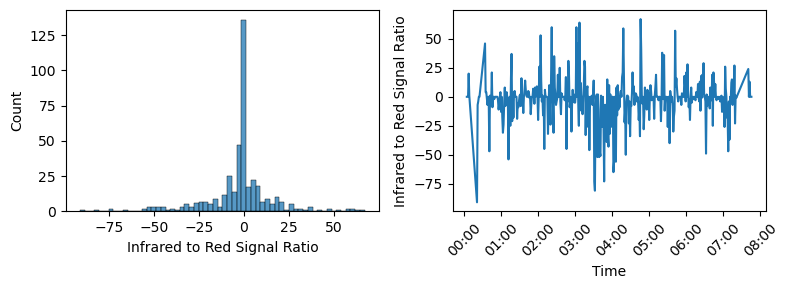

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sns.histplot(ax=axs[0], data=example_o2var['Infrared to Red Signal Ratio'])
sns.lineplot(ax=axs[1], data=example_o2var['Infrared to Red Signal Ratio']).set(xlabel='Time')
myFmt = mdates.DateFormatter('%H:%M')
axs[1].xaxis.set_major_formatter(myFmt)
axs[1].tick_params(axis='x', rotation=45)
plt.tight_layout()

In [4]:
rolling_tstep = 10
example_o2var['rolling_EOV'] = -example_o2var['Infrared to Red Signal Ratio'].rolling(rolling_tstep, center=True).mean().fillna(0) # Get Red to Infrared Ratio
example_o2var['error'] = example_o2var['Infrared to Red Signal Ratio'].rolling(rolling_tstep, center=True).std().fillna(0)

In [5]:
def plot_eov_date(index, EOV):
    
    colors = []
    # Determine color for each y value
    for yi in EOV:
        if yi < 25:
            colors.append('green')
        else:
            colors.append('orange')
    
    # Plotting the line with segmented colors
    plt.figure(figsize=(6.5, 2))
    plt.plot(index, EOV, color=colors[0])  # Make a green plot underneath
    
    for i in range(1, len(index)):
        if colors[i] != colors[0]: # Plot orange where needed
            plt.plot(index[(i - 1):(i + 2)], EOV[(i - 1):(i + 2)], color=colors[i])
    
    myFmt = mdates.DateFormatter('%H:%M')
    plt.gca().xaxis.set_major_formatter(myFmt)
    
    # Adding dotted line at y=25
    plt.axhline(y=25, color='black', linestyle='--')
    # Adding solid line at y=5
    plt.axhline(y=5, color='black')
    
    plt.xlabel('DateTime')
    plt.ylabel('10-Step Rolling average R:IR')
    plt.xticks(index[::60])
    plt.xticks(rotation=45)
    plt.title('Estimated Oxygen Variation')
    plt.show()    

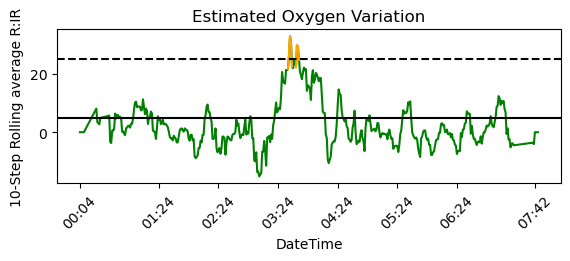

In [6]:
plot_eov_date(example_o2var.index, example_o2var['rolling_EOV'].values)

## 2) Calculate high EOV fluctuations per night

In [7]:
eov_files = glob.glob(path+"estimated_oxygen_variation*")
summary_df = pd.DataFrame(columns=['File','Date', 'Min_EOVLow', 'Min_EOVHigh','Num_EOVSpikes'])
EOV_dfs = {}

for file in eov_files:
    EOV_df = pd.read_csv(file)
    EOV_df['dateTime'] = pd.to_datetime(EOV_df['timestamp'], format="%m/%d/%y %H:%M:%S")
    EOV_df = EOV_df.set_index('dateTime').drop(columns='timestamp')
    EOV_df['EOV'] = -EOV_df['Infrared to Red Signal Ratio'].rolling(rolling_tstep, center=True).mean().fillna(0)
    
    EOV_df['EOV_high'] = np.where(EOV_df['EOV'] > 25, True, False)
    
    date = EOV_df.index[0].date()
    
    # Special case where no high o2 variations are detected
    
    if EOV_df['EOV_high'].value_counts()[False] == EOV_df.shape[0]:
        Min_High = 0
    else:
        Min_High = EOV_df['EOV_high'].value_counts()[True]
    
    Min_Low = EOV_df['EOV_high'].value_counts()[False]
    Num_Spikes = (EOV_df['EOV_high'] & (EOV_df['EOV_high'] != EOV_df['EOV_high'].shift(1))).sum()
    
    EOV_dfs[date] = EOV_df
    summary_df.loc[len(summary_df.index)] = [file, date, Min_Low, Min_High, Num_Spikes]
    #print(file + ' Complete')  

In [8]:
# Only take data from 2023-05-01 onwards
summary_df = summary_df[summary_df['Date'] > datetime.date(2023, 5, 1)].copy()

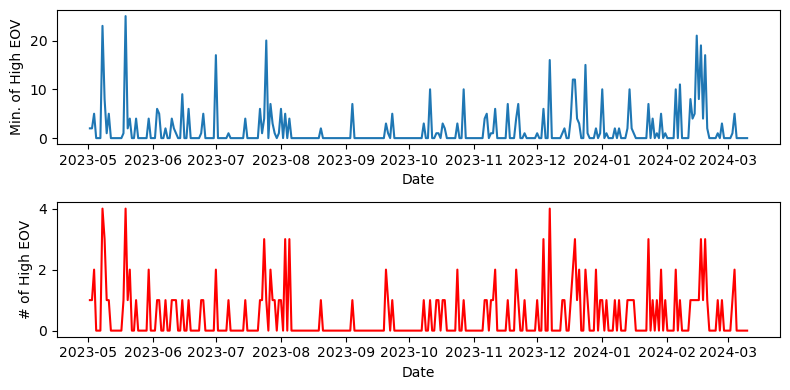

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(8, 4))

sns.lineplot(data=summary_df, y = 'Min_EOVHigh',  x = 'Date', ax = axes[0]).set(ylabel='Min. of High EOV')
sns.lineplot(data=summary_df, y = 'Num_EOVSpikes',  x = 'Date', ax = axes[1], color='red').set(ylabel='# of High EOV')
plt.tight_layout()

Text(0.5, 1.0, 'High EOV with Poisson Fit: λ = 0.46')

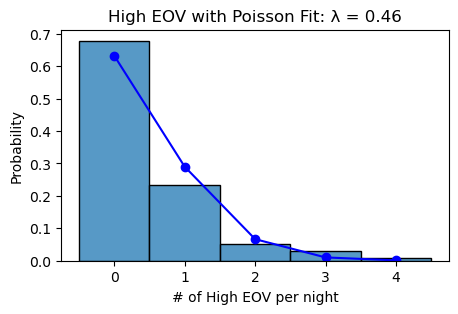

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3))

lambda_ = np.mean(summary_df['Num_EOVSpikes'])
x = np.arange(0, np.max(summary_df['Num_EOVSpikes'])+1)

# Create a Poisson Probability Mass Function
pmf = poisson.pmf(x, lambda_)

sns.histplot(summary_df['Num_EOVSpikes'], binwidth=1, discrete=True, stat='probability').set(xlabel='# of High EOV per night')
plt.plot(x, pmf, 'bo-', label='poisson pmf')
plt.title(f"High EOV with Poisson Fit: λ = {lambda_:.2f}")

## 3) Random permutation control

For each sleep, calculate a random permutation of the raw data, and process it the same way. Principal questions are:
1) For nights with no high spikes, how often does a random permutation cause one to occur?
2) For nights with high spikes, how often does a random permutation cause them to dissapear?

In [28]:
summary_df['Num_EOVSpikes_Rd'] = summary_df['Num_EOVSpikes'].copy()

for i, (date, df) in enumerate(EOV_dfs.items()):
    df_temp = df.copy()
    df_temp['Raw_Random_Permutation'] = df_temp['Infrared to Red Signal Ratio'].sample(frac=1).values
    df_temp['EOV_Random'] = -df_temp['Raw_Random_Permutation'].rolling(rolling_tstep, center=True).mean().fillna(0)
    df_temp['EOV_Random_high'] = np.where(df_temp['EOV_Random'] > 25, True, False)
    
    Num_Spikes = (df_temp['EOV_Random_high'] & (df_temp['EOV_Random_high'] != df_temp['EOV_Random_high'].shift(1))).sum()
    summary_df.loc[i, 'Num_EOVSpikes_Rd'] = Num_Spikes

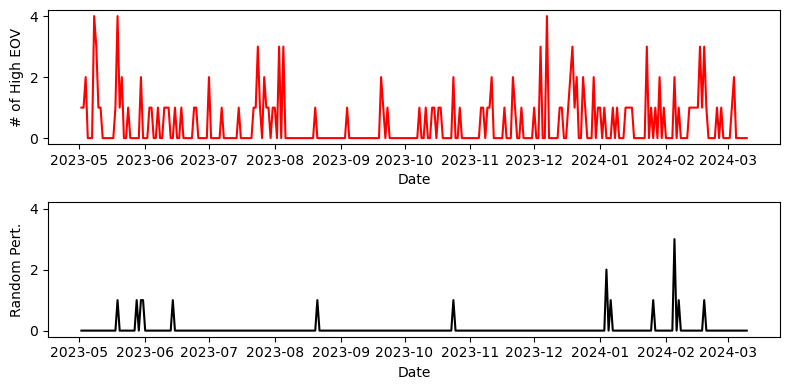

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(8, 4), sharey=True)

sns.lineplot(data=summary_df, y = 'Num_EOVSpikes',  x = 'Date', ax = axes[0], color='red').set(ylabel='# of High EOV')
sns.lineplot(data=summary_df, y = 'Num_EOVSpikes_Rd',  x = 'Date', ax = axes[1], color='black').set(ylabel='Random Pert.')
plt.tight_layout()

In [30]:
summary_df[['Num_EOVSpikes','Num_EOVSpikes_Rd']].value_counts()

Num_EOVSpikes  Num_EOVSpikes_Rd
0.0            0.0                 206
1.0            0.0                  72
2.0            0.0                  13
3.0            0.0                   8
0.0            1.0                   6
2.0            1.0                   2
4.0            0.0                   2
0.0            2.0                   1
1.0            1.0                   1
2.0            3.0                   1
3.0            1.0                   1
4.0            1.0                   1
Name: count, dtype: int64